<a href="https://colab.research.google.com/github/Szymonnnn/predykcja-meczow/blob/main/Programowanie_genetyczne_deap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import bibliotek

In [1]:
!pip install deap
!pip install networkx
!pip install -q condacolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached deap-1.3.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (139 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.3 MB/s eta 0:00:00


In [2]:
import condacolab
condacolab.install()
!conda install pygraphviz

✨🍰✨ Everything looks OK!
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.



In [3]:
from deap import gp, creator, base, tools, algorithms
import operator
import random
import math

Import danych

In [4]:
import pandas as pd
df = pd.read_csv('Food_for_NN.csv',  encoding= 'unicode_escape')
data = df[['1', '0', '2', '10', '2.1', '12', 'Remisy', 'WygraneL', 'WygraneR', 'Ilosc_zagranych', 'Forma_L', 'Forma_R', 'Tabela_L', 'Tabela_R', 'Pkt_tabela_L', 'Pkt_tabela_R', 'LastWygrL', 'LastWygrR', 'wygraneL', 'wygraneR', 'wynik']]

X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

X = X.values.tolist()
y = y.values.tolist()

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.30,
    random_state=1234
)

Dodanie prymitywów - zbioru funkcji z których będzie budowane drzewo

In [6]:
def _div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", len(X[0]))
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(_div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

Zmiana nazwy argumentów

In [7]:
pset.renameArguments(ARG0='w1')
pset.renameArguments(ARG1='w0')
pset.renameArguments(ARG2='w2')
pset.renameArguments(ARG3='w10')
pset.renameArguments(ARG4='w02')
pset.renameArguments(ARG5='w12')
pset.renameArguments(ARG6='Remisy')
pset.renameArguments(ARG7='WygraneL')
pset.renameArguments(ARG8='WygraneR')
pset.renameArguments(ARG9='Ilosc_zagranych')
pset.renameArguments(ARG10='Forma_L')
pset.renameArguments(ARG11='Forma_R')
pset.renameArguments(ARG12='Tabela_L')
pset.renameArguments(ARG13='Tabela_R')
pset.renameArguments(ARG14='Pkt_tabela_L')
pset.renameArguments(ARG15='Pkt_tabela_R')
pset.renameArguments(ARG16='LastWygrL')
pset.renameArguments(ARG17='LastWygrR')
pset.renameArguments(ARG18='wygraneL')
pset.renameArguments(ARG19='wygraneR')

Stworzenie środowiska do ewolucji

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [9]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalFunc(X, y, individual):
    func = toolbox.compile(expr=individual)

    sum_loss = 0

    for i in range(len(y)):
        x=X[i]
        out = func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19])-y[i]
        sum_loss += abs(out)

    avg_loss = sum_loss/len(y)
    return avg_loss, pow(avg_loss, 2)


toolbox.register("evaluate", evalFunc, X_train, y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [10]:
import numpy
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [11]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 80, stats=mstats, halloffame=hof, verbose=True)

   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max        	min     	nevals	std        	avg    	gen	max	min	nevals	std    
0  	300   	1.44434e+33	0  	8.50516e+35	0.445508	300   	3.46983e+34	74.4567	0  	853	7  	300   	82.1435
1  	170   	6.51981e+06	1  	3.87807e+09	0.267076	170   	1.58193e+08	51.8   	1  	853	1  	170   	67.6631
2  	167   	0.964523   	2  	63.0246    	0.267076	167   	3.09053    	37.58  	2  	191	1  	167   	25.2305
3  	166   	1.30182    	3  	339.041    	0.267076	166   	13.8193    	40.5933	3  	183	1  	166   	24.0975
4  	178   	0.928736   	4  	81.1065    	0.267076	178   	3.65388    	41.2267	4  	105	1  	178   	22.384 
5  	159   	1.43764e+23	5  	8.62583e+25	0.267076	159   	3.51854e+24	43.44  	5  	103	2  	159   	21.1666
6  	182   	0.829

10


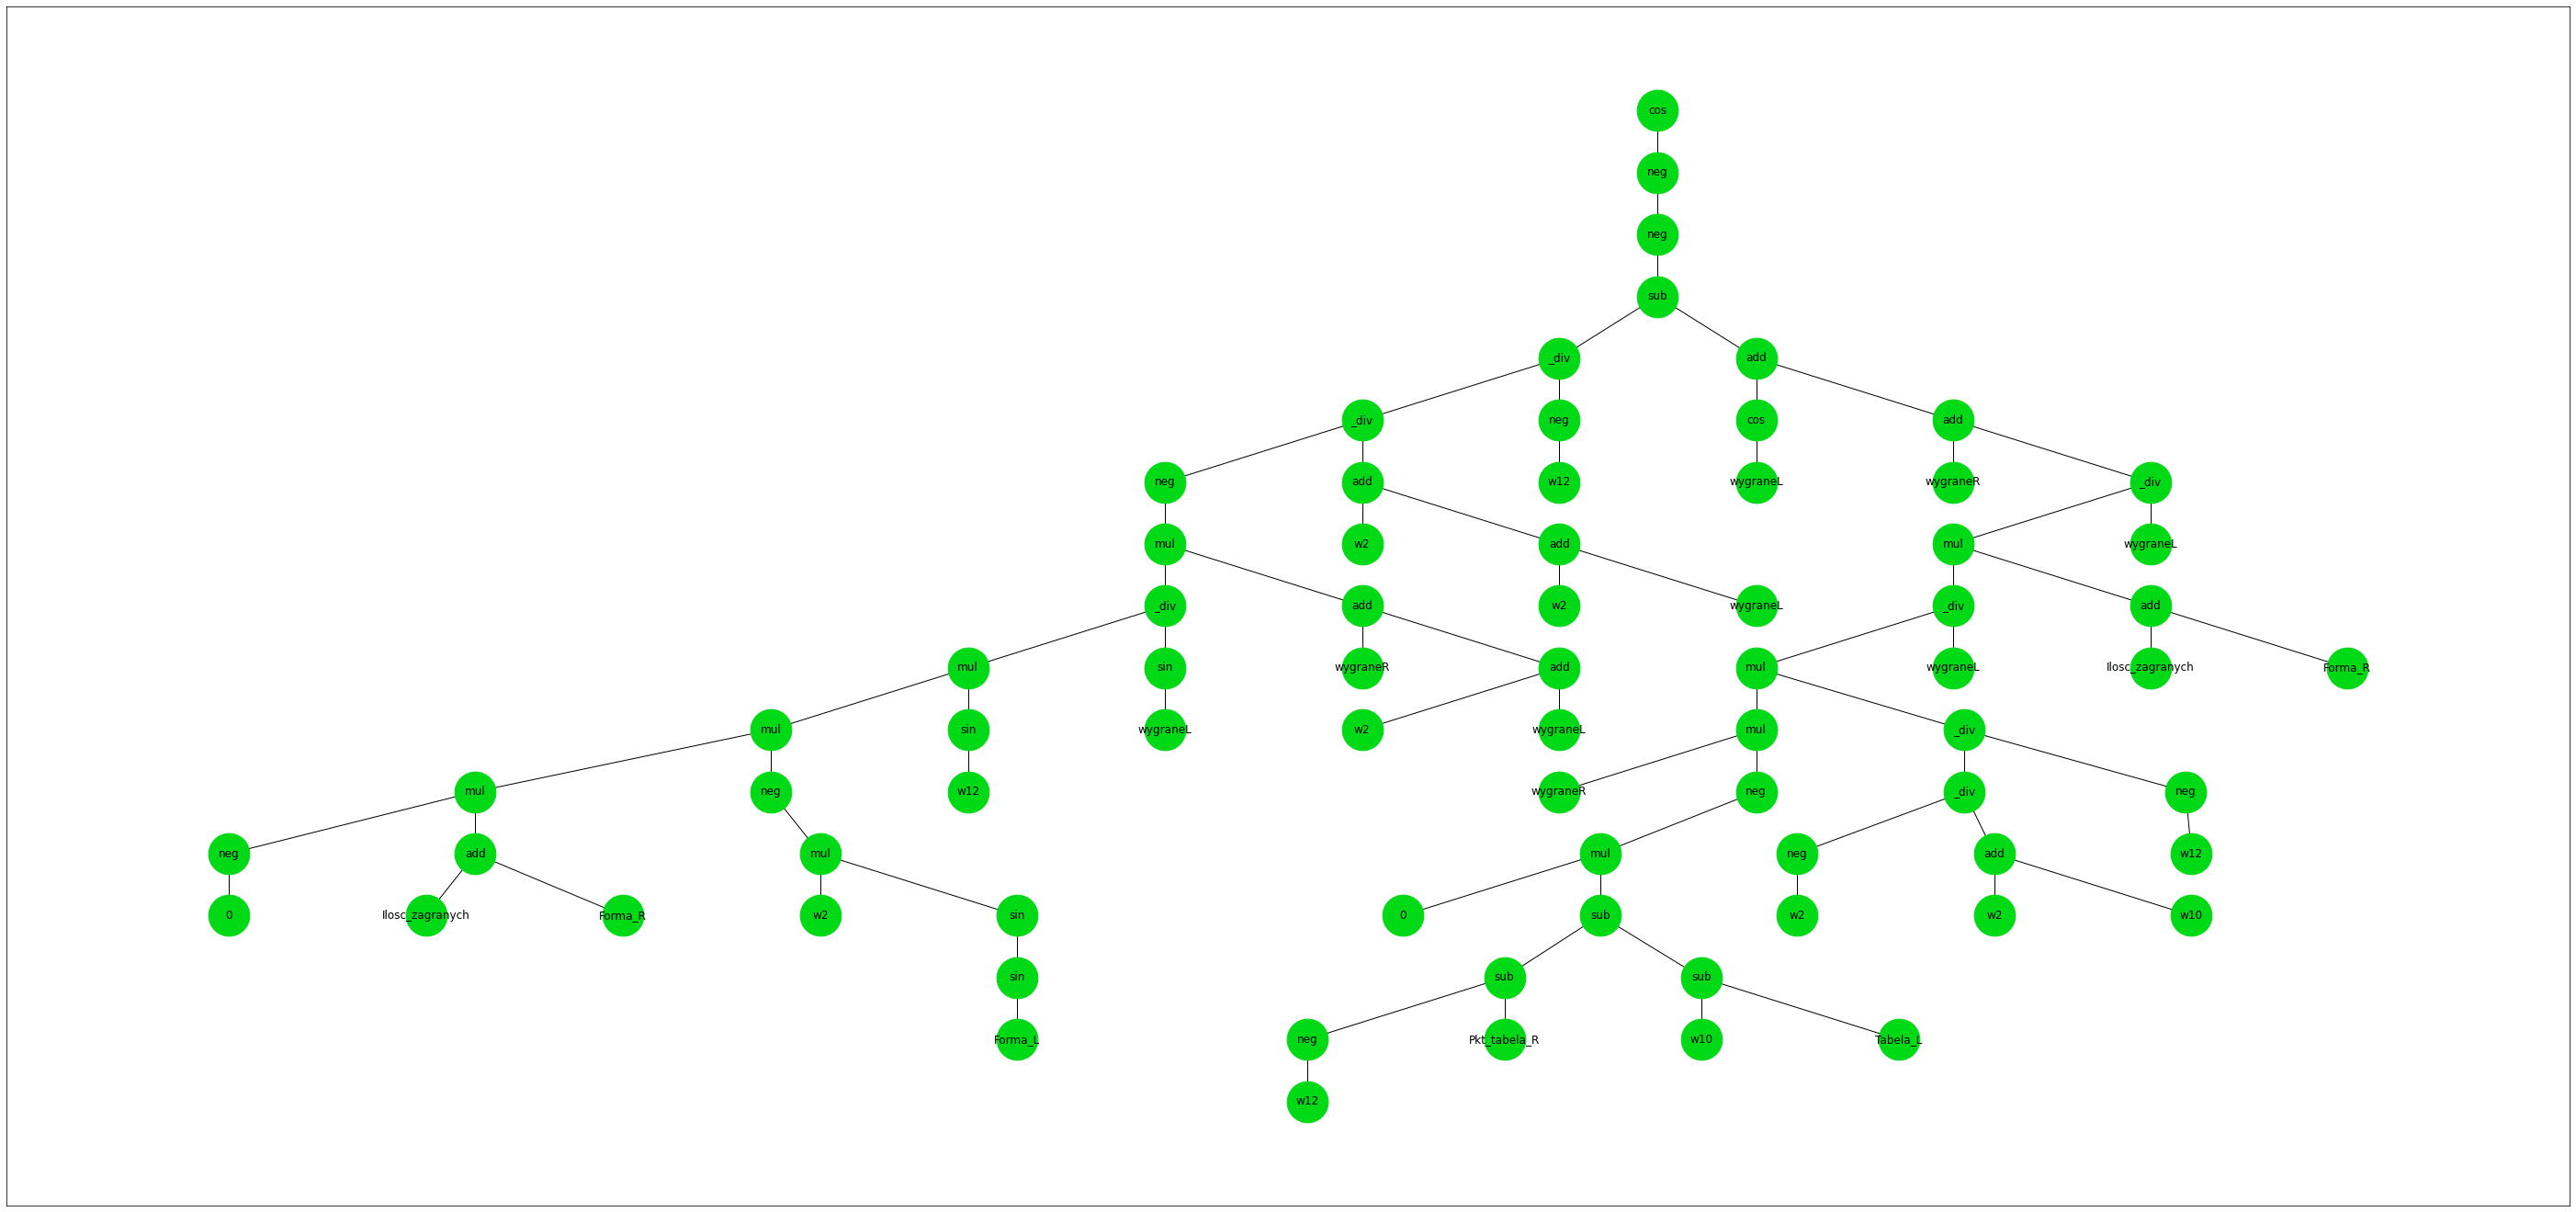

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
print(len(hof))

nodes, edges, labels = gp.graph(hof[0])
plt.rcParams["figure.figsize"] = (50,24)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)


pos = graphviz_layout(g, prog="dot")
nx.draw_networkx_nodes(g, pos, node_size=2000, node_color='#00d916')
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)

plt.plot(figsize=(8, 6), dpi=80)
plt.savefig("drzewo.png")

In [13]:
mean = 0
for i in range(len(hof)):
    func = toolbox.compile(expr=hof[i])
    x=X[0]
    f = func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19])
    mean += f
    print(f)
mean = mean/len(hof)
print()
print(mean)

0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714
0.9146533258523714

0.9146533258523715


In [14]:
predict = []
func = toolbox.compile(expr=hof[0])

for i in range(len(y_test)):
    x = X_test[i]
    predict.append(func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19]))

In [15]:
err = 0
for i in range(len(y_test)):
    err += pow(predict[i]-y_test[i], 2)
err = err/len(y_test)
print("MSE: ", round(err, 3))

MSE:  0.114


In [16]:
choices = []
for i in range(len(y_test)):
    if predict[i]>0.5:
        choices.append(1)
    elif predict[i]>-0.5:
        choices.append(0)
    else:
        choices.append(-1)

In [17]:
scores = 0
for i in range(len(y_test)):
    if choices[i] == y_test[i]:
        scores += 1

accuracy_score = scores/len(y_test)
print(accuracy_score)

0.9368587213891081


In [18]:
for i in range(len(y_test)):
    print(y_test[i],"   ", predict[i])

-1     -0.9906352181686892
0     -0.013056465670730854
1     0.834344819917976
0     0.030489295156121407
1     0.9600369302946615
0     0.030489295156121407
1     0.8575532158463934
-1     -0.35791368136602925
1     0.834344819917976
0     -0.4252256433423121
0     -0.013056465670730854
0     -0.4252256433423121
1     0.9406158641517484
1     0.834344819917976
1     0.9146533258523714
1     0.834344819917976
0     -0.04750639652378794
1     0.9999499253557712
1     0.834344819917976
1     0.8575532158463934
1     0.5486961336030971
1     0.5486961336030971
0     -0.009035483030959772
1     0.9146533258523714
0     -0.04457351561385713
1     0.9999499253557712
0     -0.029199522301288815
0     0.030489295156121407
-1     -0.36353446144332957
0     -0.009035483030959772
1     0.8575532158463934
1     0.8575532158463934
0     0.030489295156121407
-1     -0.7977951344268761
0     0.030489295156121407
1     0.9146533258523714
-1     -0.8246063428921
-1     -0.36798479307589754
1     0.8575

In [64]:
exit()